In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
def sphere(x):
    return np.inner(x,x)

In [23]:
value = sphere
bounds = [-1,1]
nparams = 4
nants = None
archive_size = None
maxit = 2
diverse = 0.5
evap = 0.85
seed = None

In [26]:
"""
Minimize the objective function using ACO-R.

ACO-R stands for Ant Colony Optimization for Continuous Domains (Socha and
Dorigo, 2008).

Parameters:

* value : function
    Returns the value of the objective function at a given parameter vector
* bounds : list
    The bounds of the search space. If only two values are given, will
    interpret as the minimum and maximum, respectively, for all parameters.
    Alternatively, you can given a minimum and maximum for each parameter,
    e.g., for a problem with 3 parameters you could give
    `bounds = [min1, max1, min2, max2, min3, max3]`.
* nparams : int
    The number of parameters that the objective function takes.
* nants : int
    The number of ants to use in the search. Defaults to the number of
    parameters.
* archive_size : int
    The number of solutions to keep in the solution archive. Defaults to
    10 x nants
* maxit : int
    The number of iterations to run.
* diverse : float
    Scalar from 0 to 1, non-inclusive, that controls how much better
    solutions are favored when constructing new ones.
* evap : float
    The pheromone evaporation rate (evap > 0). Controls how spread out the
    search is.
* seed : None or int
    Seed for the random number generator.

Yields:

* estimate : 1d-array
    The best estimate at each iteration

"""
numpy.random.seed(seed)
# Set the defaults for number of ants and archive size
if nants is None:
    nants = nparams
if archive_size is None:
    archive_size = 10 * nants
# Check is giving bounds for each parameter or one for all
bounds = numpy.array(bounds)
if bounds.size == 2:
    low, high = bounds
    archive = numpy.random.uniform(low, high, (archive_size, nparams))
else:
    archive = numpy.empty((archive_size, nparams))
    bounds = bounds.reshape((nparams, 2))
    for i, bound in enumerate(bounds):
        low, high = bound
        archive[:, i] = numpy.random.uniform(low, high, archive_size)
# Compute the inital pheromone trail based on the objetive function value
trail = numpy.fromiter((value(p) for p in archive), dtype=numpy.float)
# Sort the archive
order = numpy.argsort(trail)
archive = [archive[i] for i in order]
trail = trail[order].tolist()
# The first of the archive is the best solution found
# yield archive[0]
# Compute the weights (probabilities) of the solutions in the archive
amp = 1. / (diverse * archive_size * numpy.sqrt(2 * numpy.pi))
variance = 2 * diverse ** 2 * archive_size ** 2
weights = amp * numpy.exp(-numpy.arange(archive_size) ** 2 / variance)
weights /= numpy.sum(weights)
for iteration in xrange(maxit):
    for k in xrange(nants):
        # Sample the propabilities to produce new estimates
        ant = numpy.empty(nparams, dtype=numpy.float)
        # 1. Choose a pdf from the archive
        pdf = numpy.searchsorted(
            numpy.cumsum(weights),
            numpy.random.uniform())
        print(pdf)
        for i in xrange(nparams):
            # 2. Get the mean and stddev of the chosen pdf
            mean = archive[pdf][i]
            std = (evap / (archive_size - 1)) * numpy.sum(
                abs(p[i] - archive[pdf][i]) for p in archive)
            # 3. Sample the pdf until the samples are in bounds
            for atempt in xrange(100):
                ant[i] = numpy.random.normal(mean, std)
                if bounds.size == 2:
                    low, high = bounds
                else:
                    low, high = bounds[i]
                if ant[i] >= low and ant[i] <= high:
                    break
        print(ant)
        pheromone = value(ant)
        # Place the new estimate in the archive
        place = numpy.searchsorted(trail, pheromone)
        if place == archive_size:
            continue
        trail.insert(place, pheromone)
        trail.pop()
        archive.insert(place, ant)
        archive.pop()
#     yield archive[0]

2
[-0.65597938  0.16011252  0.30239519 -0.25926863]
1
[ 0.22867613 -0.97668961 -0.18357236  0.29257145]
7
[-0.41653257  0.79952992 -0.38416859 -0.73633809]
11
[-0.04611468  0.0483724   0.05135982 -0.02372143]
6
[-0.45744365  0.62943729 -0.34876834 -0.12161928]
14
[-0.5826332   0.45879956 -0.24258567  0.93929653]
6
[-0.33013881  0.97637893  0.87152574 -0.15482468]
14
[ 0.2460038  -0.29898905  0.16569625  0.90588701]


In [17]:
std

0.24685222443595406

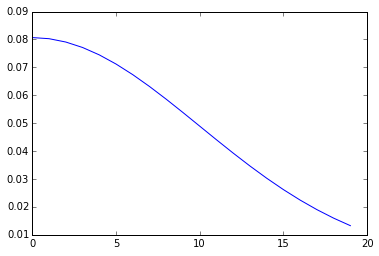

In [16]:
plot(weights)

In [14]:
trail

[0.002129257445994094,
 0.054989829713957723,
 0.07904577656125028,
 0.08693356497458174,
 0.093599372752120574,
 0.11172465737164347,
 0.18104632405551807,
 0.1924930368394926,
 0.22269324801291485,
 0.25048922069955126,
 0.29069452802690154,
 0.2919404479868708,
 0.29916911777350863,
 0.31747444488372811,
 0.331599810035784,
 0.38536202760532701,
 0.39283707758080988,
 0.4420528887532182,
 0.44665176466029455,
 0.45618965436112868]

In [ ]:
max_num_iterations=1000
solver = acor(sphere, [-1,1], 2, maxit=max_num_iterations)
iterations = 0
residuals = []
solutions = []
for p in solver:
    iterations = iterations + 1
    residual = sphere(p)
    residuals.append(residual)
    solutions.append(p)
    continue
print(iterations)
solutions = np.array(solutions).reshape(-1, 2)

In [ ]:
import matplotlib.animation as animation

fig = plt.figure()
plt.clf()
scat = plt.scatter(solutions[0][0], solutions[0][1])
plt.xlim((-1,1))
plt.ylim((-1,1))

def update_plot(i, data, scat):
    data = solutions[i]
    scat.set_offsets(data)
    return scat,

ani = animation.FuncAnimation(fig,
                              update_plot, frames=xrange(max_num_iterations),
                                  fargs=([], scat),interval=25, blit=False)
plt.show()